In [ ]:
#Conecta o Google Drive
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import os

#Caminho para os arquivos JSON
data_path = '/content/drive/My Drive/T2_IA'

#Função para carregar dados de um arquivo JSON
def load_data(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [ ]:
#Carrega os dados
subir = load_data(os.path.join(data_path, 'Subir.json'))
cair = load_data(os.path.join(data_path, 'Cair.json'))
parado = load_data(os.path.join(data_path, 'Parado.json'))

#Unifica os dados em uma lista com labels
data = []
for item in subir:
    data.append({'descricao': item['descricao'], 'categoria': 'subir'})
for item in cair:
    data.append({'descricao': item['descricao'], 'categoria': 'cair'})
for item in parado:
    data.append({'descricao': item['descricao'], 'categoria': 'parado'})

print(f"Total de noticias: {len(data)}")

Total de noticias: 1469


In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(data)
df.head()

,descricao,categoria
0,Crise política no Brasil gera instabilidade e ...,subir
1,"Inflação dispara no Brasil, atingindo o maior ...",subir
2,Dívida pública brasileira ultrapassa 90% do PI...,subir
3,Queda na produção industrial brasileira reduz ...,subir
4,Aumento de juros no Brasil reduz consumo e des...,subir


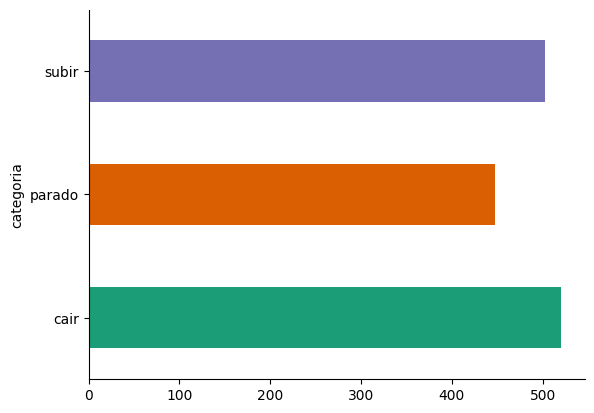

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('categoria').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:


from sklearn.model_selection import train_test_split

#Divide os dados em treino, validação e teste
train_data, test_data = train_test_split(data, test_size=0.15, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print(f"Treino: {len(train_data)}, Validação: {len(val_data)}, Teste: {len(test_data)}")




Treino: 1060, Validação: 188, Teste: 221


In [ ]:
#Instala pacotes necessários para o treinamento
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets

In [ ]:
!pip install wandb -qU

In [ ]:
# Log in to your W&B account
import wandb
import random
import math

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: emerson-o (emerson-o-ufms-universidade-federal-de-mato-grosso-do-sul). Use `wandb login --relogin` to force relogin


True

0b261285951feb5beddd21833242681b6fbb55f4

# **distilbert-base-uncased**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset

model_name = "distilbert-base-uncased"

#Carrega o tokenizer e o modelo
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Mapea as categorias para labels
category_to_label = {
    'cair': 0,
    'parado': 1,
    'subir': 2
}

def add_labels(examples):
    examples['label'] = category_to_label[examples['categoria']]
    return examples

#Adiciona rótulos aos datasets
train_dataset = Dataset.from_list(train_data).map(add_labels)
val_dataset = Dataset.from_list(val_data).map(add_labels)
test_dataset = Dataset.from_list(test_data).map(add_labels)

Map:   0%|          | 0/1060 [00:00<?, ? examples/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

Map:   0%|          | 0/221 [00:00<?, ? examples/s]

In [ ]:
#Função para tokenizar os dados
def tokenize_function(examples):
    return tokenizer(examples['descricao'], truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

#Remove colunas desnecessárias e definir a coluna de rótulo
train_dataset = train_dataset.remove_columns(['descricao', 'categoria']).with_format("torch")
val_dataset = val_dataset.remove_columns(['descricao', 'categoria']).with_format("torch")
test_dataset = test_dataset.remove_columns(['descricao', 'categoria']).with_format("torch")

Map:   0%|          | 0/1060 [00:00<?, ? examples/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

Map:   0%|          | 0/221 [00:00<?, ? examples/s]

In [ ]:
#Prepara o data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#Configurações do treinamento
training_args = TrainingArguments(
    output_dir='/content/drive/My Drive/T2_IA/results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=1,
    logging_dir='/content/drive/My Drive/T2_IA/logs',
    logging_steps=10
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
#Função para calcular as métricas
def compute_metrics(p):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


In [ ]:
#Criando o trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

<ipython-input-18-7a7c7162ecfa>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
#Treina o modelo
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.270000,0.228777,0.925532,0.926381,0.938403,0.925532
2,0.207500,0.102894,0.968085,0.968363,0.970708,0.968085
3,0.061400,0.170408,0.962766,0.963130,0.966288,0.962766
4,0.006100,0.089158,0.973404,0.973540,0.974223,0.973404
5,0.014300,0.134671,0.968085,0.968303,0.970708,0.968085
6,0.003100,0.147310,0.973404,0.973540,0.974223,0.973404
7,0.002300,0.064471,0.984043,0.984103,0.984726,0.984043
8,0.002200,0.069753,0.984043,0.984103,0.984726,0.984043
9,0.001900,0.091378,0.978723,0.978853,0.979922,0.978723
10,0.001800,0.087504,0.984043,0.984103,0.984726,0.984043


TrainOutput(global_step=670, training_loss=0.0888681077078652, metrics={'train_runtime': 2681.9152, 'train_samples_per_second': 3.952, 'train_steps_per_second': 0.25, 'total_flos': 94901129813592.0, 'train_loss': 0.0888681077078652, 'epoch': 10.0})

In [ ]:
#Avalia no conjunto de teste
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(test_results)

#Predições no conjunto de teste
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)

#Relatório de classificação
from sklearn.metrics import classification_report

labels = test_dataset['label']
print(classification_report(labels, preds, target_names=['cair', 'parado', 'subir']))


{'eval_loss': 0.14254236221313477, 'eval_accuracy': 0.9773755656108597, 'eval_f1': 0.9775241716948585, 'eval_precision': 0.9780959600050919, 'eval_recall': 0.9773755656108597, 'eval_runtime': 14.3289, 'eval_samples_per_second': 15.423, 'eval_steps_per_second': 0.977, 'epoch': 10.0}
              precision    recall  f1-score   support

        cair       0.94      0.98      0.96        66
      parado       0.99      0.97      0.98        69
       subir       1.00      0.98      0.99        86

    accuracy                           0.98       221
   macro avg       0.98      0.98      0.98       221
weighted avg       0.98      0.98      0.98       221



In [ ]:
save_path = '/content/drive/My Drive/T2_IA/modelo_treinadoDistilbert'  #Caminho para salvar o modelo

In [ ]:
# Salvar o melhor modelo no Google Drive
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/My Drive/T2_IA/modelo_treinadoDistilbert/tokenizer_config.json',
 '/content/drive/My Drive/T2_IA/modelo_treinadoDistilbert/special_tokens_map.json',
 '/content/drive/My Drive/T2_IA/modelo_treinadoDistilbert/vocab.txt',
 '/content/drive/My Drive/T2_IA/modelo_treinadoDistilbert/added_tokens.json',
 '/content/drive/My Drive/T2_IA/modelo_treinadoDistilbert/tokenizer.json')

# **bert-base-uncased**

In [ ]:
model_name = "bert-base-uncased"

#Carrega o tokenizer e o modelo
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Mapea as categorias para labels
category_to_label = {
    'cair': 0,
    'parado': 1,
    'subir': 2
}

def add_labels(examples):
    examples['label'] = category_to_label[examples['categoria']]
    return examples

#Adiciona rótulos aos datasets
train_dataset = Dataset.from_list(train_data).map(add_labels)
val_dataset = Dataset.from_list(val_data).map(add_labels)
test_dataset = Dataset.from_list(test_data).map(add_labels)

Map:   0%|          | 0/1060 [00:00<?, ? examples/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

Map:   0%|          | 0/221 [00:00<?, ? examples/s]

In [ ]:
#Função para tokenizar os dados
def tokenize_function(examples):
    return tokenizer(examples['descricao'], truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

#Remove colunas desnecessárias e definir a coluna de rótulo
train_dataset = train_dataset.remove_columns(['descricao', 'categoria']).with_format("torch")
val_dataset = val_dataset.remove_columns(['descricao', 'categoria']).with_format("torch")
test_dataset = test_dataset.remove_columns(['descricao', 'categoria']).with_format("torch")

Map:   0%|          | 0/1060 [00:00<?, ? examples/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

Map:   0%|          | 0/221 [00:00<?, ? examples/s]

In [ ]:
#Prepara o data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#Configurações do treinamento
training_args = TrainingArguments(
    output_dir='/content/drive/My Drive/T2_IA/results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=1,
    logging_dir='/content/drive/My Drive/T2_IA/logs',
    logging_steps=10
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
#Função para calcular as métricas
def compute_metrics(p):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


In [ ]:
#Criando o trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

<ipython-input-28-7a7c7162ecfa>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
#Treina o modelo
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.277700,0.253905,0.920213,0.919808,0.927008,0.920213
2,0.207800,0.309298,0.925532,0.926614,0.938403,0.925532
3,0.164100,0.083624,0.978723,0.978686,0.979407,0.978723
4,0.025100,0.077180,0.989362,0.989347,0.989670,0.989362
5,0.001900,0.088606,0.984043,0.984103,0.984726,0.984043
6,0.001200,0.084278,0.989362,0.989347,0.989670,0.989362
7,0.001400,0.092507,0.984043,0.984032,0.984106,0.984043
8,0.000900,0.090942,0.984043,0.984032,0.984106,0.984043
9,0.000900,0.086475,0.989362,0.989347,0.989670,0.989362
10,0.000800,0.086519,0.989362,0.989347,0.989670,0.989362


TrainOutput(global_step=670, training_loss=0.09044142612603619, metrics={'train_runtime': 4986.4212, 'train_samples_per_second': 2.126, 'train_steps_per_second': 0.134, 'total_flos': 188494041345624.0, 'train_loss': 0.09044142612603619, 'epoch': 10.0})

In [ ]:
#Avalia no conjunto de teste
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(test_results)

#Predições no conjunto de teste
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)

#Relatório de classificação
from sklearn.metrics import classification_report

labels = test_dataset['label']
print(classification_report(labels, preds, target_names=['cair', 'parado', 'subir']))


{'eval_loss': 0.13966108858585358, 'eval_accuracy': 0.9773755656108597, 'eval_f1': 0.9773775519527728, 'eval_precision': 0.9776397490852895, 'eval_recall': 0.9773755656108597, 'eval_runtime': 27.1405, 'eval_samples_per_second': 8.143, 'eval_steps_per_second': 0.516, 'epoch': 10.0}
              precision    recall  f1-score   support

        cair       0.96      0.98      0.97        66
      parado       0.99      0.96      0.97        69
       subir       0.99      0.99      0.99        86

    accuracy                           0.98       221
   macro avg       0.98      0.98      0.98       221
weighted avg       0.98      0.98      0.98       221



In [ ]:
save_path = '/content/drive/My Drive/T2_IA/modelo_treinadoBert'  #Caminho para salvar o modelo

In [ ]:
# Salvar o melhor modelo no Google Drive
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/My Drive/T2_IA/modelo_treinadoBert/tokenizer_config.json',
 '/content/drive/My Drive/T2_IA/modelo_treinadoBert/special_tokens_map.json',
 '/content/drive/My Drive/T2_IA/modelo_treinadoBert/vocab.txt',
 '/content/drive/My Drive/T2_IA/modelo_treinadoBert/added_tokens.json',
 '/content/drive/My Drive/T2_IA/modelo_treinadoBert/tokenizer.json')

# TELEGRAM

In [ ]:
#Monta Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Caminho para o modelo salvo
save_path = '/content/drive/My Drive/T2_IA/modelo_treinadoDistilbert'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers
!pip install python-telegram-bot==13.7

In [ ]:
import logging
from telegram import Update
from telegram.ext import Updater, CommandHandler, MessageHandler, CallbackContext, Filters
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [ ]:
#Carregar o modelo e o tokenizer salvos
model_name = "Distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(save_path)
model = AutoModelForSequenceClassification.from_pretrained(save_path)


In [ ]:
#Mapeamento de categorias
label_to_category = {
    0: 'Cair',
    1: 'Não sair do lugar',
    2: 'Subir'
}

#Função para classificar produtos
def classify_product(descricao):
    inputs = tokenizer(descricao, return_tensors="pt", truncation=True)
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_label = torch.argmax(predictions, dim=1).item()
    return label_to_category[predicted_label]

#Token do bot (substitua pelo seu token)
TELEGRAM_TOKEN = "7239221335:AAFP7bbLzO8NXco1lqKi8CdQyzYoF3wsS4k"

#Configurar logging
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

#Função de start
def start(update: Update, context: CallbackContext) -> None:
    update.message.reply_text('Olá! Envie o texto da noticia relacionada a dinheiro saber para onde o Dolar vai!!!')

#Função para responder mensagens
def classify(update: Update, context: CallbackContext) -> None:
    descricao = update.message.text
    category = classify_product(descricao)
    update.message.reply_text(f'O Dolar tem a tendencia de {category}')

#Função de ajuda
def help_command(update: Update, context: CallbackContext) -> None:
    update.message.reply_text(' Envie o texto da noticia relacionada a dinheiro saber para onde o Dolar vai!!!')

#Função principal
def main() -> None:
    updater = Updater(TELEGRAM_TOKEN, use_context=True)

    dispatcher = updater.dispatcher

    dispatcher.add_handler(CommandHandler("start", start))
    dispatcher.add_handler(CommandHandler("help", help_command))
    dispatcher.add_handler(MessageHandler(Filters.text & ~Filters.command, classify))

    updater.start_polling()
    updater.idle()

if __name__ == '__main__':
    main()